#### This notebook gives the mstm-wrapper results for 1 sphere, in order to compare to mie.py for debugging

In [13]:
import mstm
import matplotlib
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
from mpl_toolkits.mplot3d import Axes3D

### First, let's calculate scattered intensity as a function of theta, for a fixed phi = 0
The target has 1 sphere of radius 0.125 um, and the incident is horizontally polarized. The incident has 2pi/lamba = 15.7 ==> lambda = 0.4 um

/run/user/27040/gvfs/smb-share:server=manoharanfs1.rc.fas.harvard.edu,share=manoharanfs1/stephenson/Code/Repositories/mstm-wrapper/mstm/__init__.py:60: RuntimeWarning: divide by zero encountered in log10
  b, e = num/10**(np.floor(np.log10(np.abs(num)))), np.floor(np.log10(np.abs(num)))
/run/user/27040/gvfs/smb-share:server=manoharanfs1.rc.fas.harvard.edu,share=manoharanfs1/stephenson/Code/Repositories/mstm-wrapper/mstm/__init__.py:60: RuntimeWarning: invalid value encountered in true_divide
  b, e = num/10**(np.floor(np.log10(np.abs(num)))), np.floor(np.log10(np.abs(num)))


<IPython.core.display.Javascript object>


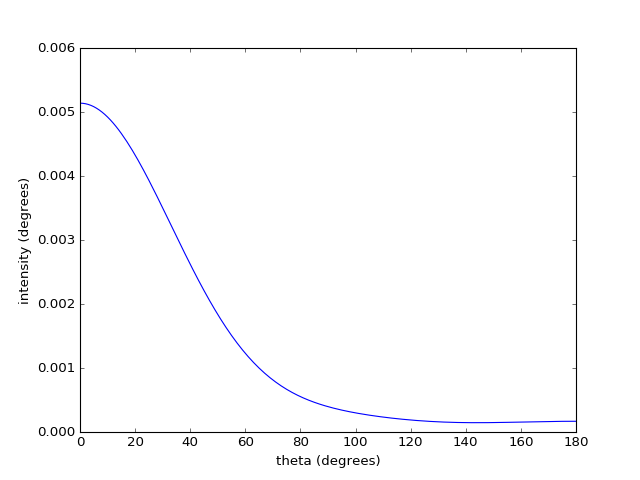

In [14]:
num_spheres = 1
xpos = np.array([0])
ypos = np.array([0])
zpos = np.array([0])
radii = np.array([0.125])
n_matrix = 1.0
n_spheres = 1.54
theta = np.arange(0, 181, 1)
phi = np.array([0])
jones_vec = [1, 0]
stokes_vec = [1, 1, 0, 0]
length_scl_factor = np.array([15.7])

# make target object
target = mstm.Target(xpos, ypos, zpos, radii, n_matrix, n_spheres, num_spheres)

# make incident object
incident = mstm.Incident(jones_vec, stokes_vec, length_scl_factor)
    
# calculate the intensities
intensity_data = mstm.calc_intensity(target, incident, theta, phi)

# plot intensity versus theta
plt.plot(theta, intensity_data[0,:,2])
plt.xlabel('theta (degrees)')
plt.ylabel('intensity (degrees)')

### Next, let's calculate the scattered intensity as a function of theta and phi
The target has 1 sphere of radius 0.125 um, and the incident is horizontally polarized. The incident has 2pi/lamba = 15.7 ==> lambda = 0.4 um

/run/user/27040/gvfs/smb-share:server=manoharanfs1.rc.fas.harvard.edu,share=manoharanfs1/stephenson/Code/Repositories/mstm-wrapper/mstm/__init__.py:60: RuntimeWarning: divide by zero encountered in log10
  b, e = num/10**(np.floor(np.log10(np.abs(num)))), np.floor(np.log10(np.abs(num)))
/run/user/27040/gvfs/smb-share:server=manoharanfs1.rc.fas.harvard.edu,share=manoharanfs1/stephenson/Code/Repositories/mstm-wrapper/mstm/__init__.py:60: RuntimeWarning: invalid value encountered in true_divide
  b, e = num/10**(np.floor(np.log10(np.abs(num)))), np.floor(np.log10(np.abs(num)))


<IPython.core.display.Javascript object>


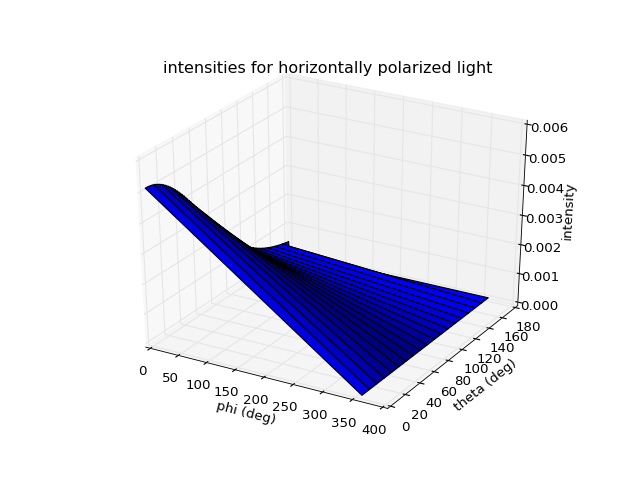

In [15]:
num_spheres = 1
xpos = np.array([0])
ypos = np.array([0])
zpos = np.array([0])
radii = np.array([0.125])
n_matrix = 1.0
n_spheres = 1.54
theta = np.arange(0, 181, 1)
phi = np.array([0, 361])
jones_vec = [1, 0]
stokes_vec = [1, 1, 0, 0]
length_scl_factor = np.array([15.7])

# make target object
target = mstm.Target(xpos, ypos, zpos, radii, n_matrix, n_spheres, num_spheres)

# make incident object 
incident = mstm.Incident(jones_vec, stokes_vec, length_scl_factor)
    
# calculate the intensities
intensity_data = mstm.calc_intensity(target, incident, theta, phi)
Is = intensity_data[0,:,2]

plt.figure()
ax = plt.axes(projection = '3d')
Is3d = np.zeros((len(theta),len(phi)))
cnt = 0
for i in range(0,len(theta)-1):    
    for j in range(0,len(phi)-1):
        Is3d[i][j] = Is[cnt]
        cnt = cnt + 1
p,t=np.meshgrid(phi,theta)
ax.plot_surface(p,t,Is3d)
ax.set_zlabel('intensity')
plt.xlabel('phi (deg)')
plt.ylabel('theta (deg)')
plt.title('intensities for horizontally polarized light')

### Now we calculuate the intensity as a function of theta and phi, but for vertically polarized incident light
The target has 1 sphere of radius 0.125 um, and the incident is horizontally polarized. The incident has 2pi/lamba = 15.7 ==> lambda = 0.4 um

/run/user/27040/gvfs/smb-share:server=manoharanfs1.rc.fas.harvard.edu,share=manoharanfs1/stephenson/Code/Repositories/mstm-wrapper/mstm/__init__.py:60: RuntimeWarning: divide by zero encountered in log10
  b, e = num/10**(np.floor(np.log10(np.abs(num)))), np.floor(np.log10(np.abs(num)))
/run/user/27040/gvfs/smb-share:server=manoharanfs1.rc.fas.harvard.edu,share=manoharanfs1/stephenson/Code/Repositories/mstm-wrapper/mstm/__init__.py:60: RuntimeWarning: invalid value encountered in true_divide
  b, e = num/10**(np.floor(np.log10(np.abs(num)))), np.floor(np.log10(np.abs(num)))


<IPython.core.display.Javascript object>


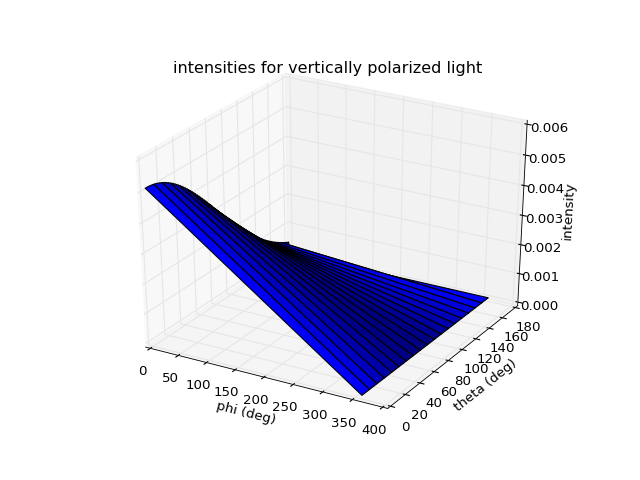

In [16]:
num_spheres = 1
xpos = np.array([0])
ypos = np.array([0])
zpos = np.array([0])
radii = np.array([0.125])
n_matrix = 1.0
n_spheres = 1.54
theta = np.arange(0, 181, 1)
phi = np.array([0, 361])
jones_vec = [0, 1]
stokes_vec = [1, -1, 0, 0]
length_scl_factor = np.array([15.7])

# make target object
target = mstm.Target(xpos, ypos, zpos, radii, n_matrix, n_spheres, num_spheres)

# make incident object 
incident = mstm.Incident(jones_vec, stokes_vec, length_scl_factor)
    
# calculate the intensities
intensity_data = mstm.calc_intensity(target, incident, theta, phi)
Is = intensity_data[0,:,2]

plt.figure()
ax = plt.axes(projection = '3d')
Is3d = np.zeros((len(theta),len(phi)))
cnt = 0
for i in range(0,len(theta)-1):    
    for j in range(0,len(phi)-1):
        Is3d[i][j] = Is[cnt]
        cnt = cnt + 1
p,t=np.meshgrid(phi,theta)
ax.plot_surface(p,t,Is3d)
ax.set_zlabel('intensity')
plt.xlabel('phi (deg)')
plt.ylabel('theta (deg)')
plt.title('intensities for vertically polarized light')

We can see that the intensity plots for the two polarizations appear similar in shape, but the peak is wider for the vertically polarized one. They also appear to have no dependence on phi except for a barely perceptible bump around phi = 50 degrees. This is not consistent with what we expect to see because:

1. we expect to see a dependence on phi
2. we expect that the intensities should not be identical for the two polarization, but only that their integrals should be identical

### Now let's look at the integrated Intensities as a function of wavelength

/run/user/27040/gvfs/smb-share:server=manoharanfs1.rc.fas.harvard.edu,share=manoharanfs1/stephenson/Code/Repositories/mstm-wrapper/mstm/__init__.py:60: RuntimeWarning: divide by zero encountered in log10
  b, e = num/10**(np.floor(np.log10(np.abs(num)))), np.floor(np.log10(np.abs(num)))
/run/user/27040/gvfs/smb-share:server=manoharanfs1.rc.fas.harvard.edu,share=manoharanfs1/stephenson/Code/Repositories/mstm-wrapper/mstm/__init__.py:60: RuntimeWarning: invalid value encountered in true_divide
  b, e = num/10**(np.floor(np.log10(np.abs(num)))), np.floor(np.log10(np.abs(num)))


<IPython.core.display.Javascript object>


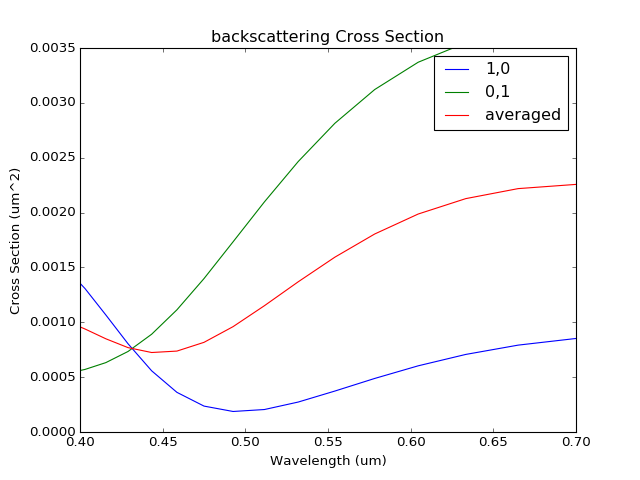

In [18]:
num_spheres = 1
xpos = np.array([1])
ypos = np.array([1])
zpos = np.array([0])
radii = np.array([0.125])
n_matrix = 1.0
n_spheres = 1.54
theta = np.arange(90, 181, 1) # this theta range is for back-scattering cross section
phi = np.arange(0, 361, 1)
jones_vec = [1, 0]
stokes_vec = [1, 1, 0, 0]
min_wavelength = 0.35
max_wavelength = 0.7
length_scl_factor = np.linspace(2*np.pi/max_wavelength, 2*np.pi/min_wavelength, num = 20)

# make the target object
target = mstm.Target(xpos, ypos, zpos, radii, n_matrix, n_spheres, num_spheres)

# make incident object horizontally polarized
incident = mstm.Incident(jones_vec, stokes_vec, length_scl_factor)

# calculate the cross section
cross_section1 = mstm.calc_cross_section(target, incident, theta, phi)

# make incident object vertically polarized
incident2 = mstm.Incident([0, 1], [1, -1, 0, 0], length_scl_factor)

# calculate the cross section
cross_section2 = mstm.calc_cross_section(target, incident2, theta, phi)

plt.figure()
plt.plot(2*np.pi/length_scl_factor, cross_section1, 2*np.pi/length_scl_factor, cross_section2, 
         2*np.pi/length_scl_factor, (cross_section1+cross_section2)/2)
plt.legend(['1,0','0,1','averaged'])
plt.xlabel('Wavelength (um)')
plt.xlim([0.4,0.7])
plt.ylim([0,0.0035])
plt.ylabel('Cross Section (um^2)')
plt.title('backscattering Cross Section')